# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'total_return', 'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'

# Data

## Universe: KOSPI200

In [3]:
k200 = DataManager(
    universe = 'kospi200',
    file = 'kospi200_prices_240707lst.csv',
    path = path_data
)
k200.upload()

200 assets from 2000-03-06 to 2024-07-05 uploaded.
df_prices updated


In [4]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

In [5]:
cond = df_k200.notna().sum(axis=1) > 170
df_k200 = df_k200.loc[cond].dropna(axis=1)
df_k200.columns.size

171

## Ratios

In [6]:
WidgetUniverse

In [7]:
file = 'kospi200_ratios.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 171 stocks from 2017-05-31 to 2024-09-30 loaded


In [8]:
start = df_k200.index.min()
#tickers = df_k200.columns.to_list()[:3]
tickers = df_k200.columns.to_list()

fr.download(tickers, start) if WidgetUniverse.values(0) else None

In [9]:
fr.df_ratios

BPS    PER   PBR     EPS   DIV    DPS
ticker date                                                 
005930 2017-05-31  1156530  14.43  1.97  157967  1.25  28500
       2017-06-30  1156530  14.14  1.93  157967  1.28  28500
       2017-07-31  1156530  14.95  2.04  157967  1.21  28500
       2017-08-31  1156530  15.38  2.10  157967  1.17  28500
       2017-09-30  1156530  14.71  2.01  157967  1.23  28500
...                    ...    ...   ...     ...   ...    ...
000670 2024-05-31  2216785   0.00  0.18       0  2.48  10000
       2024-06-30  2216785   0.00  0.17       0  2.66  10000
       2024-07-31  2216785   0.00  0.15       0  2.95  10000
       2024-08-31  2216785   0.00  0.14       0  3.17  10000
       2024-09-30  2216785   0.00  0.14       0  3.23  10000

[15219 rows x 6 columns]

In [10]:
fr.calc_rank(metrics='PER', date='start', topn=None)

Ranking score of PER on 2017-05-31


ticker
081660    0.000000
002710    0.006667
015760    0.013333
000270    0.020000
006650    0.026667
            ...   
009420    0.973333
009150    0.980000
008930    0.986667
011070    0.993333
241560    1.000000
Name: PER, Length: 151, dtype: float64

In [11]:
fr.calc_historical()

Historical of PER ranking score created


ticker  date      
005930  2017-05-31    0.489097
        2017-06-30    0.464174
        2017-07-31    0.495327
        2017-08-31    0.501558
        2017-09-30    0.489097
                        ...   
000670  2024-05-31    0.000000
        2024-06-30    0.000000
        2024-07-31    0.000000
        2024-08-31    0.000000
        2024-09-30    0.000000
Name: PER, Length: 15219, dtype: float64

In [12]:
fr.calc_historical(['PER', 'PBR'])

Historical of PER+PBR ranking score created


ticker  date      
005930  2017-05-31    1.170513
        2017-06-30    1.133791
        2017-07-31    1.197392
        2017-08-31    1.200673
        2017-09-30    1.155763
                        ...   
000670  2024-05-31    0.011765
        2024-06-30    0.011765
        2024-07-31    0.005882
        2024-08-31    0.000000
        2024-09-30    0.000000
Name: PER, Length: 15219, dtype: float64

## Reshape for backtest

In [14]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

PER interpolated from 2017-05-10 to 2024-07-05
PBR interpolated from 2017-05-10 to 2024-07-05


# Backtest

In [15]:
df_p = fr.util_reshape(df_k200)

fratio = 'PER'
df_ratio = fr.interpolate(df_p, fratio)
df_ratio = fr.util_reshape(df_ratio, stack=False)

PER interpolated from 2017-05-10 to 2024-07-05


In [31]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [32]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [33]:
#bm.buy_n_hold(name='PER', weigh='equally')

In [34]:
select = 'f-ratio'
kwargs_build = dict(
    name=f'{select}', select =select,
    n_assets=10, weigh='Equally', freq='Y',
    df_ratio=df_ratio, ratio_ascending=True
)
bm.build(**kwargs_build)

Backtesting 2 strategies: KODEX200, f-ratio


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.21it/s]

Returning stats


,f-ratio,KODEX200
start,2017-05-09,2017-05-09
end,2024-07-05,2024-07-05
total_return,1.405582,0.546137
cagr,0.130491,0.06278
calmar,0.267879,0.164829
max_drawdown,-0.487128,-0.380878
avg_drawdown,-0.056481,-0.040377
avg_drawdown_days,62.325,78.46875
daily_vol,0.256396,0.182733
daily_sharpe,0.618062,0.432525


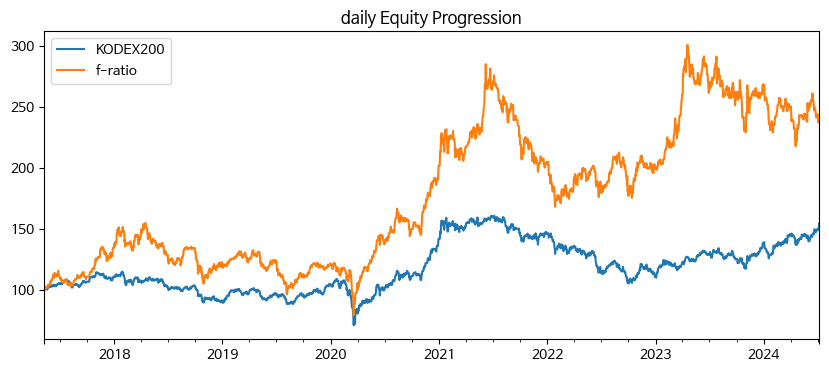

In [35]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [36]:
bm.portfolios

0) KODEX200
1) f-ratio

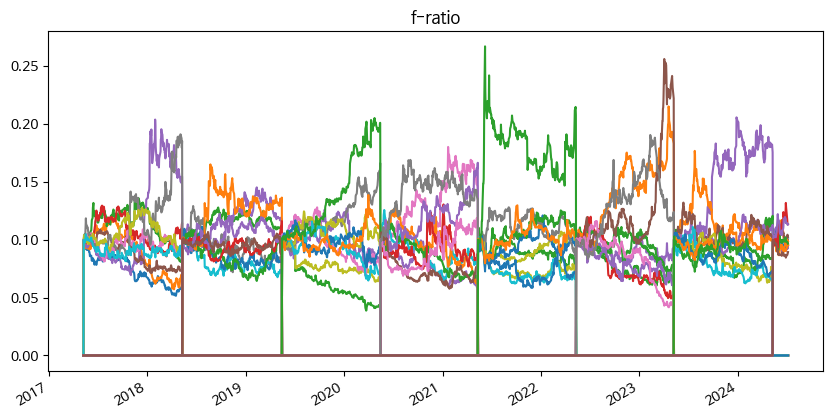

In [37]:
bm.plot_security_weights(1, legend=False)

## Parameter study

In [23]:
n_test = 250
df_train = df_k200.iloc[:-n_test]
df_test = df_k200.iloc[-n_test-250:]

In [24]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

In [25]:
bm = BacktestManager(df_train, **kwargs_bm)

running self.util_check_days_in_year to check days in a year


In [26]:
bm.benchmark_ticker()

Benchmark is KODEX200


In [27]:
from itertools import product

params = dict(
    #p_fr = ['PER', 'PBR', 'PER+PBR'],
    p_fr = ['PER', 'PBR'],
    p_ast = [5,10,20,30],
    p_freq = [130, 250, 500]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}',
             'n_assets':x[1], 'freq':x[2], 'df_ratio':fratios_dict[x[0]]} for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_ascending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

In [28]:
df_res = bm.run(stats_sort_by='monthly_sharpe', plot=False)
df_res.iloc[:, :5]

Backtesting 25 strategies: KODEX200, PER:a5/f130, ... , PBR:a30/f500


100%|███████████████████████████████████████████████████████████████| 25/25 [00:21<00:00,  1.15it/s]


Returning stats


,PER:a5/f500,PER:a5/f130,PER:a10/f500,PER:a10/f130,PER:a5/f250
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28
total_return,2.388793,1.551276,1.273431,1.153287,1.182958
cagr,0.220083,0.164918,0.143231,0.133159,0.135689
calmar,0.524536,0.314144,0.329456,0.276895,0.271402
max_drawdown,-0.419577,-0.524978,-0.434749,-0.480899,-0.499955
avg_drawdown,-0.05531,-0.048668,-0.05564,-0.043941,-0.060596
avg_drawdown_days,41.66,34.733333,58.833333,40.365385,57.72973
daily_vol,0.269436,0.250739,0.232347,0.218663,0.262187
daily_sharpe,0.890183,0.748523,0.705987,0.694884,0.627312


In [29]:
bm.portfolios

0) KODEX200
1) PER:a5/f130
2) PER:a5/f250
3) PER:a5/f500
4) PER:a10/f130
5) PER:a10/f250
6) PER:a10/f500
7) PER:a20/f130
8) PER:a20/f250
9) PER:a20/f500
10) PER:a30/f130
11) PER:a30/f250
12) PER:a30/f500
13) PBR:a5/f130
14) PBR:a5/f250
15) PBR:a5/f500
16) PBR:a10/f130
17) PBR:a10/f250
18) PBR:a10/f500
19) PBR:a20/f130
20) PBR:a20/f250
21) PBR:a20/f500
22) PBR:a30/f130
23) PBR:a30/f250
24) PBR:a30/f500

In [39]:
#pf_list = [0, 3, 1, 6, 4]
pf_list = list(range(7))
bm.get_stats(pf_list, sort_by='monthly_sharpe')

,PER:a5/f500,PER:a5/f130,PER:a10/f500,PER:a10/f130,PER:a5/f250,PER:a10/f250,KODEX200
start,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09,2017-05-09
end,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28,2023-06-28
total_return,2.388793,1.551276,1.273431,1.153287,1.182958,0.577198,0.290628
cagr,0.220083,0.164918,0.143231,0.133159,0.135689,0.077091,0.042459
calmar,0.524536,0.314144,0.329456,0.276895,0.271402,0.153986,0.111625
max_drawdown,-0.419577,-0.524978,-0.434749,-0.480899,-0.499955,-0.500638,-0.38037
avg_drawdown,-0.05531,-0.048668,-0.05564,-0.043941,-0.060596,-0.058475,-0.04033
avg_drawdown_days,41.66,34.733333,58.833333,40.365385,57.72973,82.653846,66.8125
daily_vol,0.269436,0.250739,0.232347,0.218663,0.262187,0.219436,0.184606
daily_sharpe,0.890183,0.748523,0.705987,0.694884,0.627312,0.456136,0.322683


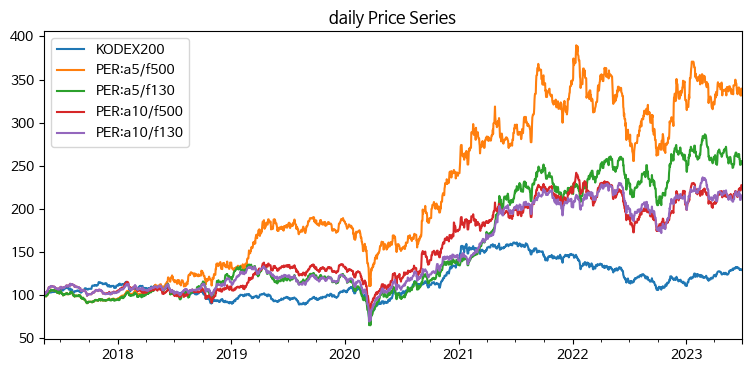

In [34]:
_ = bm.plot(pf_list, figsize=(9,4))

### Validation

In [44]:
bm = BacktestManager(df_test, **kwargs_bm)
bm.benchmark_ticker()

running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


Backtesting 5 strategies: KODEX200, PER:a5/f130, PER:a5/f250, PER:a10/f130, PER:a10/f250


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.95it/s]

Returning stats


,KODEX200,PER:a5/f130,PER:a5/f250,PER:a10/f130,PER:a10/f250
start,2022-06-26,2022-06-26,2022-06-26,2022-06-26,2022-06-26
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,0.307593,0.354263,0.337132,0.041092,0.039694
cagr,0.141534,0.161465,0.15419,0.020075,0.019399
calmar,0.953443,0.751864,0.717987,0.095895,0.096055
max_drawdown,-0.148445,-0.214753,-0.214753,-0.209345,-0.201956
avg_drawdown,-0.030484,-0.061921,-0.057175,-0.066889,-0.074683
avg_drawdown_days,25.269231,37.944444,34.05,71.3,71.4
daily_vol,0.168761,0.258318,0.260772,0.209863,0.212311
daily_sharpe,0.88523,0.719883,0.691137,0.201196,0.198258


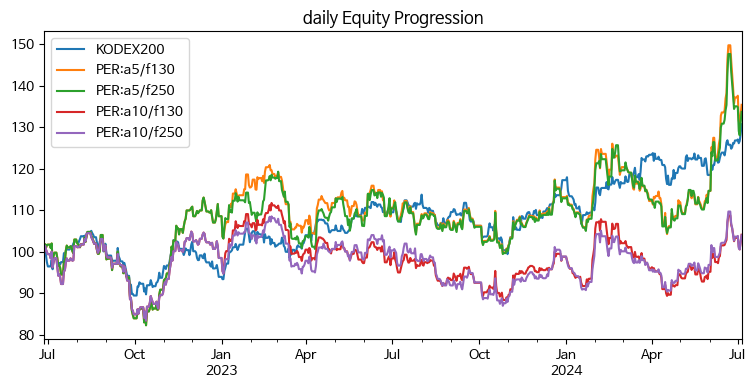

In [45]:
from itertools import product

params = dict(
    p_fr = ['PER'],
    p_ast = [5,10],
    p_freq = [130, 250]
)
p_comb = list(product(*params.values()))
kwa_list = [{'name':f'{x[0]}:a{x[1]}/f{x[2]}',
             'n_assets':x[1], 'freq':x[2], 'df_ratio':fratios_dict[x[0]]} for x in p_comb]

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_ascending=False
)

bm.build_batch(*kwa_list, **kwargs_build)
bm.run(stats_sort_by='monthly_sharpe', figsize=(9,4))

## Cross-validation

In [35]:
bm.cv_strategies

0) PER:a5/f130
1) PER:a5/f250
2) PER:a5/f500
3) PER:a10/f130
4) PER:a10/f250
5) PER:a10/f500
6) PER:a20/f130
7) PER:a20/f250
8) PER:a20/f500
9) PER:a30/f130
10) PER:a30/f250
11) PER:a30/f500
12) PBR:a5/f130
13) PBR:a5/f250
14) PBR:a5/f500
15) PBR:a10/f130
16) PBR:a10/f250
17) PBR:a10/f500
18) PBR:a20/f130
19) PBR:a20/f250
20) PBR:a20/f500
21) PBR:a30/f130
22) PBR:a30/f250
23) PBR:a30/f500

In [38]:
pf_list = list(range(6))
bm.cross_validate(pf_list, n_sample=10)

Cross-validating 6 strategies: PER:a5/f130, PER:a5/f250, ... , PER:a10/f500


100%|███████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


,PER:a5/f130,PER:a5/f250,PER:a5/f500,PER:a10/f130,PER:a10/f250,PER:a10/f500
avg_drawdown,-0.05 ± 0.006,-0.05 ± 0.018,-0.05 ± 0.012,-0.05 ± 0.007,-0.05 ± 0.008,-0.05 ± 0.007
avg_drawdown_days,38.32 ± 8.637,38.70 ± 23.780,47.74 ± 14.013,47.97 ± 10.360,44.99 ± 16.277,55.49 ± 9.220
cagr,0.16 ± 0.042,0.19 ± 0.071,0.14 ± 0.051,0.11 ± 0.015,0.12 ± 0.043,0.09 ± 0.033
calmar,0.28 ± 0.076,0.36 ± 0.169,0.24 ± 0.087,0.22 ± 0.037,0.25 ± 0.094,0.17 ± 0.072
daily_sharpe,0.73 ± 0.148,0.83 ± 0.248,0.64 ± 0.179,0.59 ± 0.066,0.64 ± 0.171,0.48 ± 0.135
daily_sortino,1.21 ± 0.251,1.38 ± 0.431,1.06 ± 0.306,0.96 ± 0.101,1.04 ± 0.286,0.78 ± 0.220
daily_vol,0.25 ± 0.005,0.25 ± 0.007,0.27 ± 0.006,0.22 ± 0.005,0.22 ± 0.008,0.23 ± 0.005
max_drawdown,-0.56 ± 0.037,-0.55 ± 0.064,-0.58 ± 0.030,-0.49 ± 0.017,-0.49 ± 0.029,-0.51 ± 0.042
monthly_sharpe,0.68 ± 0.133,0.78 ± 0.239,0.61 ± 0.163,0.57 ± 0.066,0.63 ± 0.173,0.48 ± 0.136
monthly_sortino,1.35 ± 0.315,1.59 ± 0.569,1.18 ± 0.367,1.08 ± 0.105,1.20 ± 0.381,0.86 ± 0.266


# testing